# Predicting Gross Earning of Movies in USA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
import pickle
%load_ext autoreload
%autoreload 2
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
movies = pd.DataFrame(pd.read_pickle('IMDb_20152020.pickle'))
#We gathered movie data from 2015 to 2020 from IMDb using BeautifulSoup. We scrapped multipule pages and each page has 100 movies. 

# Data Cleanning and Relationship among Factors

In [3]:
movies_df = movies.copy() 
movies_df.drop_duplicates(subset=['movie title'],inplace=True)
movies_df.set_index('movie title',inplace=True)
movies_df.info()
movies_df_drop = movies_df.dropna()
#movies_df_drop.rename(columns=lambda name: name.replace(" ", "_"), inplace=True)
movies_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7856 entries, Mulan to The Mint
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           7461 non-null   float64
 1   imdb raters           7461 non-null   float64
 2   mpaa                  3977 non-null   object 
 3   genres                7848 non-null   object 
 4   director              7848 non-null   object 
 5   writer                7827 non-null   object 
 6   stars                 7667 non-null   object 
 7   country               7856 non-null   object 
 8   language              7856 non-null   object 
 9   release date          7151 non-null   object 
 10  budget                2593 non-null   float64
 11  opening weekend       1442 non-null   float64
 12  gross usa             1536 non-null   float64
 13  cumulative worldwide  2100 non-null   float64
 14  production companies  7165 non-null   object 
 15  runtime (min)     

In [4]:
movies_df_drop.head()

,imdb rating,imdb raters,mpaa,genres,director,writer,stars,country,language,release date,budget,opening weekend,gross usa,cumulative worldwide,production companies,runtime (min)
movie title,,,,,,,,,,,,,,,,
The Invisible Man,7.1,136012.0,R,"[Horror, Mystery, Sci-Fi, Thriller]",Leigh Whannell,Leigh Whannell,"[Elisabeth Moss, Oliver Jackson-Cohen, Harriet...",Canada,English,2020-02-28,7000000.0,28205665.0,64914050.0,130722137.0,"[Universal Pictures, Blumhouse Productions, Go...",124.0
On the Basis of Sex,7.1,23877.0,PG-13,"[Biography, Drama]",Mimi Leder,Daniel Stiepleman,"[Felicity Jones, Armie Hammer, Justin Theroux]",USA,English,2019-01-11,20000000.0,686355.0,24704837.0,38755900.0,"[Alibaba Pictures, Amblin Partners, DreamWorks]",120.0
The Gentlemen,7.9,188297.0,R,"[Action, Comedy, Crime]",Guy Ritchie,Guy Ritchie,"[Matthew McConaughey, Charlie Hunnam, Michelle...",UK,English,2020-01-24,22000000.0,10651884.0,36471795.0,115171795.0,"[STX Films, Miramax, Toff Guy Films]",113.0
Knives Out,7.9,394738.0,PG-13,"[Comedy, Crime, Drama, Mystery, Thriller]",Rian Johnson,Rian Johnson,"[Daniel Craig, Chris Evans, Ana de Armas]",USA,English,2019-11-27,40000000.0,26769548.0,165363234.0,309232797.0,"[Lionsgate, Media Rights Capital (MRC), T-Street]",130.0
Bastille Day,6.3,36373.0,R,"[Action, Crime, Drama, Thriller]",James Watkins,Andrew Baldwin,"[Idris Elba, Richard Madden, Charlotte Le Bon]",UK,English,2016-11-18,20000000.0,41546.0,50269.0,14857808.0,"[StudioCanal, Anton, Amazon Prime Video]",92.0


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


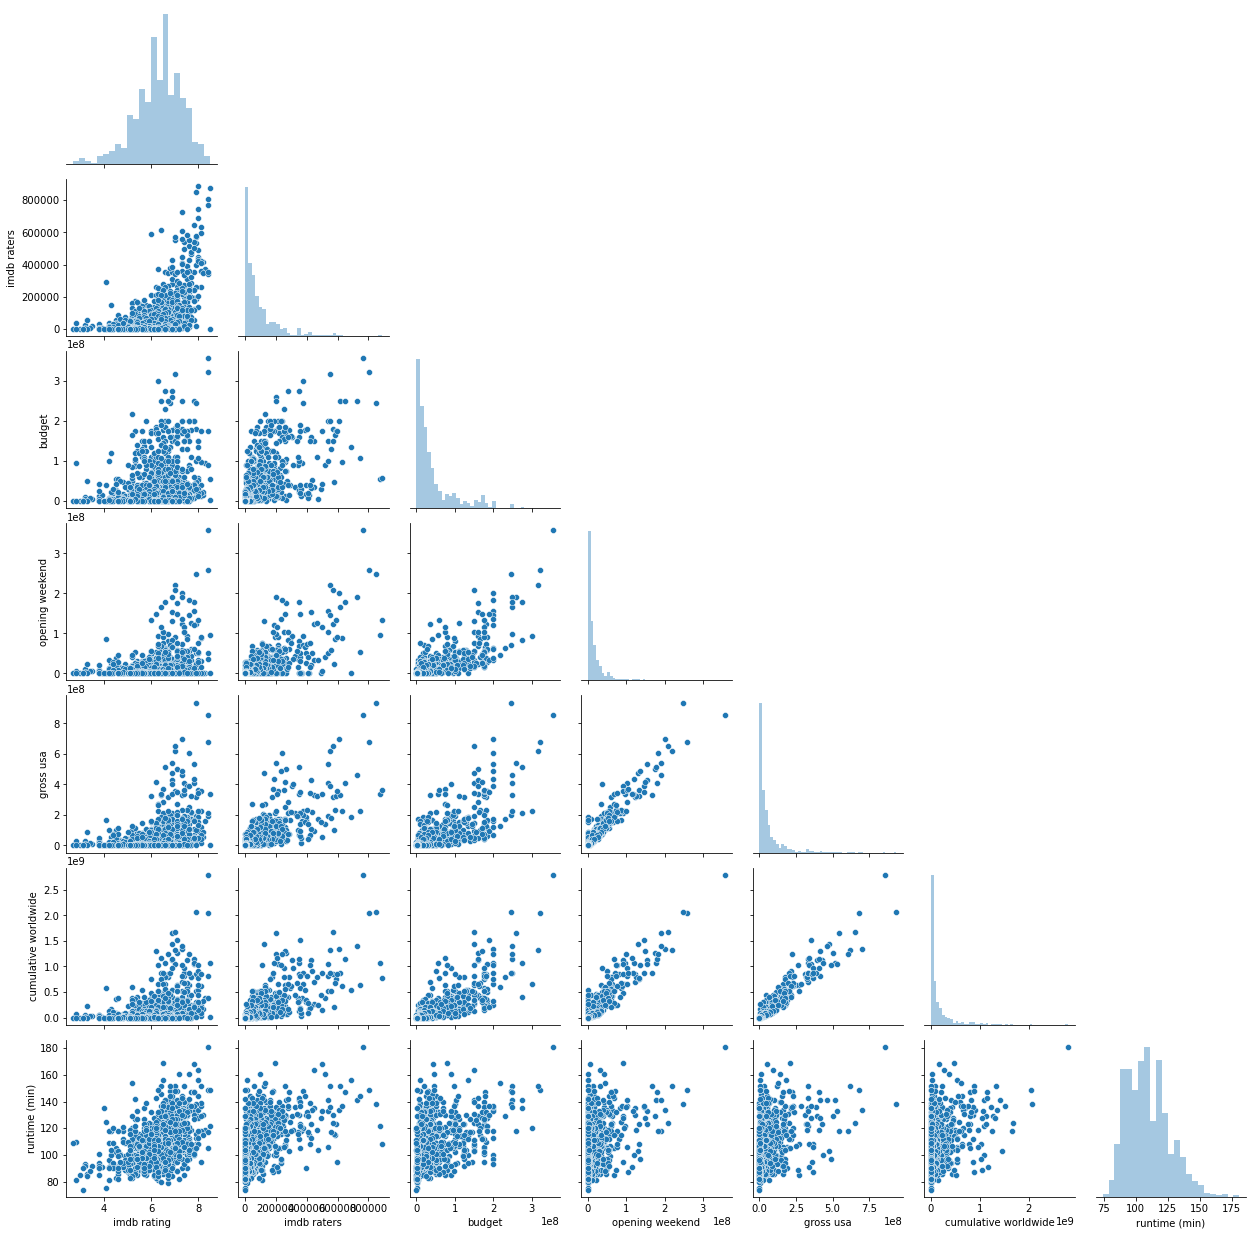

In [5]:
data=movies_df_drop[['imdb rating','imdb raters', 'budget', 'opening weekend', 'gross usa', 'cumulative worldwide', 'runtime (min)']]
g = sns.PairGrid(data, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde=False)

In [6]:
movies_df_drop.corr()

,imdb rating,imdb raters,budget,opening weekend,gross usa,cumulative worldwide,runtime (min)
imdb rating,1.000000,0.516597,0.234946,0.253542,0.333552,0.312974,0.468030
imdb raters,0.516597,1.000000,0.603180,0.702421,0.739396,0.733735,0.483198
budget,0.234946,0.603180,1.000000,0.753245,0.732849,0.793677,0.412288
opening weekend,0.253542,0.702421,0.753245,1.000000,0.956543,0.936322,0.328360
gross usa,0.333552,0.739396,0.732849,0.956543,1.000000,0.954895,0.332921
cumulative worldwide,0.312974,0.733735,0.793677,0.936322,0.954895,1.000000,0.351580
runtime (min),0.468030,0.483198,0.412288,0.328360,0.332921,0.351580,1.000000


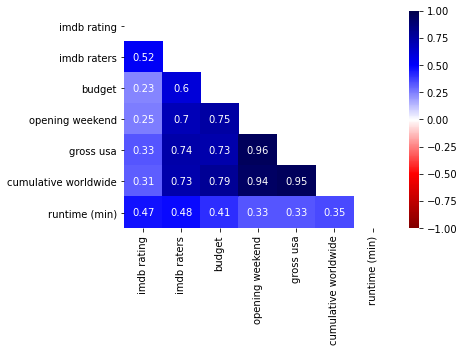

In [7]:
upper = np.triu(movies_df_drop.corr())  
sns.heatmap(movies_df_drop.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);

In [8]:
# get the correlation with gross usa
movies_df_drop.corr()['gross usa'].sort_values(ascending=False)

gross usa               1.000000
opening weekend         0.956543
cumulative worldwide    0.954895
imdb raters             0.739396
budget                  0.732849
imdb rating             0.333552
runtime (min)           0.332921
Name: gross usa, dtype: float64

# Variance Inflation Factor

In [9]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [10]:
# We only analyze the VIF for predictors
vif(movies_df_drop[['imdb rating','imdb raters', 'budget', 'opening weekend','cumulative worldwide', 'runtime (min)']])

imdb rating             44.116488
imdb raters              3.642255
budget                   4.803393
opening weekend         10.900894
cumulative worldwide    13.715302
runtime (min)           45.716972
dtype: float64

`imdb_rating` and `runtime_min  ` are both pretty high. Remember, `cumulative_worldwide` is very strongly related to `gross_usa` so we'll try to keep it. Let's remove the former pair.

In [11]:
vif(movies_df_drop[['imdb raters', 'budget', 'opening weekend', 'cumulative worldwide']])

imdb raters              3.020904
budget                   3.724876
opening weekend         10.772828
cumulative worldwide    13.005374
dtype: float64

These are better. A [rule of thumb](https://en.wikipedia.org/wiki/Variance_inflation_factor#Step_three) is to keep each VIF below 10, but take that with a grain of salt ...

# Feature Engineering

### Feature: Runtime

In [12]:
X, y = movies_df_drop[['runtime (min)']], movies_df_drop['gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.1108


### Feature: Budget

In [13]:
X, y = movies_df_drop[['budget', 'runtime (min)']], movies_df_drop['gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5382


## Try imdb rating data

In [14]:
X, y = movies_df_drop[['budget', 'runtime (min)','imdb rating']], movies_df_drop['gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5662


### Adding polynomial terms

In [15]:
X1 = X.copy()
X1['runtime (min)**2'] = X1['runtime (min)'] ** 2
X1['budget**2'] = X1['budget'] ** 2
lr = LinearRegression()
lr.fit(X1, y)
print('R-squared: {:.4f}'.format(lr.score(X1, y)))

R-squared: 0.5631


### Adding interaction terms

In [16]:
X2 = X1.copy()

# multiplicative interaction
#X3['B_x_C'] = X3['cumulative_worldwide'] * X3['budget']

# division interaction
X2['B_/_R'] = X2['budget'] / X2['runtime (min)']
lr = LinearRegression()
lr.fit(X2, y)
print('R-squared: {:.4f}'.format(lr.score(X2, y)))

R-squared: 0.5632


### Feature: MPAA Rating

In [17]:
mpaa_df = pd.get_dummies(movies_df_drop['mpaa'])

In [18]:
df_added_mpaa_dummies = pd.concat([movies_df_drop,mpaa_df], axis=1)

In [19]:
df_added_mpaa_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, The Invisible Man to Bright Ones
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           856 non-null    float64
 1   imdb raters           856 non-null    float64
 2   mpaa                  856 non-null    object 
 3   genres                856 non-null    object 
 4   director              856 non-null    object 
 5   writer                856 non-null    object 
 6   stars                 856 non-null    object 
 7   country               856 non-null    object 
 8   language              856 non-null    object 
 9   release date          856 non-null    object 
 10  budget                856 non-null    float64
 11  opening weekend       856 non-null    float64
 12  gross usa             856 non-null    float64
 13  cumulative worldwide  856 non-null    float64
 14  production companies  856 non-null    object 
 15  runt

In [20]:
X, y = df_added_mpaa_dummies[['runtime (min)','budget','G','Not Rated','PG','PG-13','R','TV-MA','Unrated']], df_added_mpaa_dummies['gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5403


### Feature: Genre

In [21]:
df_genres_added = pd.Series(df_added_mpaa_dummies['genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum(level=0)

In [22]:
df_genres_mpaa = pd.concat([df_added_mpaa_dummies, df_genres_added], axis=1)

In [24]:
df_genres_mpaa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, The Invisible Man to Bright Ones
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           856 non-null    float64
 1   imdb raters           856 non-null    float64
 2   mpaa                  856 non-null    object 
 3   genres                856 non-null    object 
 4   director              856 non-null    object 
 5   writer                856 non-null    object 
 6   stars                 856 non-null    object 
 7   country               856 non-null    object 
 8   language              856 non-null    object 
 9   release date          856 non-null    object 
 10  budget                856 non-null    float64
 11  gross usa             856 non-null    float64
 12  production companies  856 non-null    object 
 13  runtime (min)         856 non-null    float64
 14  G                     856 non-null    uint8  
 15  Not 

In [25]:
X, y = df_genres_mpaa[['runtime (min)','budget','G','Not Rated','PG','PG-13','R','TV-MA','Unrated','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']], df_genres_mpaa['gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5889


### Feature: Director

In [26]:
movies_df_drop['director'] = movies_df_drop['director'].apply(lambda x: directors_list(x))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
movies_df_drop['director'] = movies_df_drop['director'].apply(lambda x: remove_paren(x))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df_dir_exploded =movies_df_drop.explode('director')

In [29]:
dir_10 = df_dir_exploded['director'].value_counts()[1:11].index.tolist()

In [30]:
def top_directors(directors):
    dir_list = []
    for director in directors:
        if director in dir_10:
            dir_list.append(director)
    return dir_list

In [31]:
movies_df_drop['top directors'] = movies_df_drop['director'].apply(lambda x: top_directors(x))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
dir_df = pd.get_dummies(movies_df_drop['top directors'].apply(pd.Series).stack()).sum(level=0)

In [33]:
dir_df.head()

,Andrew Erwin,Clint Eastwood,Denis Villeneuve,Deon Taylor,Eli Roth,Guy Ritchie,Jon Lucas,Paul Feig,Steven Spielberg,Tyler Perry
movie title,,,,,,,,,,
The Gentlemen,0,0,0,0,0,1,0,0,0,0
Blade Runner 2049,0,0,1,0,0,0,0,0,0,0
Aladdin,0,0,0,0,0,1,0,0,0,0
Richard Jewell,0,1,0,0,0,0,0,0,0,0
A Simple Favor,0,0,0,0,0,0,0,1,0,0


In [34]:
df_dir_model = pd.concat([df_genres_mpaa, dir_df], axis=1)

In [35]:
y=movies_df_drop['gross usa']
df_dir_model.drop(labels=['imdb raters','imdb rating','gross usa','mpaa','genres','director','writer','stars','country','language','release date','production companies'],axis=1,inplace=True)

In [36]:
df_dir_model.replace(np.nan,0,inplace=True)

In [37]:
X, y = df_dir_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5911


### Feature: Writer

In [38]:
movies_df_drop['writer'].value_counts()

Tyler Perry             5
Rhett Reese             4
Christina Hodson        4
Jon Lucas               4
Leigh Whannell          4
                       ..
Stanley Tong            1
Emily Halpern           1
Christopher Borrelli    1
Fred Vassallo           1
Susannah Grant          1
Name: writer, Length: 717, dtype: int64

In [39]:
writ_df = pd.get_dummies(movies_df_drop['writer'])

In [40]:
writ_10 = movies_df_drop.writer.value_counts()[:10].index.tolist()

In [41]:
df_writ_model = pd.concat([df_dir_model,writ_df[writ_10]],axis=1)

In [42]:
X, y = df_writ_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6061


### Feature: Stars

In [43]:
stars_exploded = movies_df_drop.explode('stars')

In [44]:
stars_10 = stars_exploded['stars'].value_counts()[:10].index.tolist()

In [45]:
def top_stars(stars):
    star_list = []
    for star in stars:
        if star in stars_10:
            star_list.append(star)
    return star_list

In [46]:
movies_df_drop['top stars'] = movies_df_drop['stars'].apply(lambda x: top_stars(x))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
stars_df = pd.get_dummies(movies_df_drop['top stars'].apply(pd.Series).stack()).sum(level=0)

In [48]:
star_model = pd.concat([df_writ_model, stars_df[stars_10]], axis=1)

In [49]:
star_model.replace(np.nan,0,inplace=True)

In [50]:
X, y = star_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6173


### Feature: Production Company

In [51]:
prod_exploded = movies_df_drop.explode('production companies')

In [52]:
prod_10 = prod_exploded['production companies'].value_counts()[:10].index.tolist()

In [53]:
movies_df_drop.loc[movies_df_drop['production companies'].isnull(),'production companies'] = movies_df_drop.loc[movies_df_drop['production companies'].isnull(),'production companies'].apply(lambda x: [])

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [54]:
def top_prod(comp):
    comp_list = []
    for co in comp:
        if co in prod_10:
            comp_list.append(co)
    return comp_list

In [55]:
movies_df_drop['top prod co.'] =movies_df_drop['production companies'].apply(lambda x: top_prod(x))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
prod_df = pd.get_dummies(movies_df_drop['top prod co.'].apply(pd.Series).stack()).sum(level=0)

In [57]:
prod_model = pd.concat([star_model, prod_df[prod_10]], axis=1)

In [58]:
prod_model.replace(np.nan,0,inplace=True)

In [59]:
X, y = prod_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6489


### Feature: Release Month

In [60]:
movies_df_drop['month'] = movies_df_drop['release date'].apply(lambda x: x.strftime("%b"))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
month_df = pd.get_dummies(movies_df_drop['month'])

In [62]:
month_model = pd.concat([prod_model,month_df], axis=1)

In [63]:
X, y = month_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6526


### Feature: Years since release

In [64]:
date = pd.to_datetime(datetime.now().date())

In [65]:
movies_df_drop['years since release'] = movies_df_drop['release date'].apply(lambda x: (((date-pd.to_datetime(x))).days/ 365.25))

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
month_model['years since release'] = movies_df_drop['years since release']

In [67]:
movies_df_drop['years since release'] = movies_df_drop['years since release']

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
BeforeCovid=movies_df_drop.loc[movies_df_drop['years since release'] > 1.5]
BeforeCovid['gross usa'].mean()

64129600.560517035

In [69]:
AfterCovid=movies_df_drop.loc[movies_df_drop['years since release'] <= 1.5]
AfterCovid['gross usa'].mean()

468135.4

In [70]:
X, y = month_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6528


### Feature: Country

In [71]:
coun_df = pd.get_dummies(movies_df_drop['country'])

In [72]:
movies_df_drop['country'].value_counts()

USA                     653
UK                       94
China                    24
Canada                   24
Hong Kong                 8
France                    8
Germany                   4
Australia                 4
Mexico                    3
Japan                     3
Ireland                   3
Czech Republic            3
Malta                     2
Finland                   2
United Arab Emirates      2
Russia                    2
Spain                     2
South Korea               1
Turkey                    1
Iceland                   1
Thailand                  1
Israel                    1
Chile                     1
South Africa              1
Italy                     1
Switzerland               1
New Zealand               1
Belgium                   1
Panama                    1
Norway                    1
Denmark                   1
India                     1
Name: country, dtype: int64

In [73]:
coun_10 = movies_df_drop.country.value_counts()[:10].index.tolist()

In [74]:
df_coun_model = pd.concat([month_model,coun_df[coun_10]],axis=1)

In [75]:
X, y = df_coun_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6593


### Feature: Language

In [76]:
lan_df = pd.get_dummies(movies_df_drop['language'])

In [77]:
movies_df_drop['language'].value_counts()

English                   849
Arabic                      1
Tswana                      1
Hindi                       1
American Sign Language      1
Mandarin                    1
Hebrew                      1
Portuguese                  1
Name: language, dtype: int64

In [78]:
df_lan_model = pd.concat([df_coun_model,lan_df],axis=1)

In [79]:
X, y = df_lan_model, y
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.6611


In [80]:
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross usa   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     15.42
Date:                Tue, 12 Oct 2021   Prob (F-statistic):          2.00e-124
Time:                        10:52:52   Log-Likelihood:                -16560.
No. Observations:                 856   AIC:                         3.331e+04
Df Residuals:                     759   BIC:                         3.378e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -7.504e+07   2.58e+07     -2.913      0.004   -1.26e+08   -2.45e+07
budget                     1.2393      0.081     15.383      0.000       1.081       1.397
runtime (min)           8.104e+05   1.91e+05      4.249      0.000    4.36e+05    1.18e+06
G                      -5.647e+07   3.73e+07     -1.514      0.130    -1.3e+08    1.67e+07
Not Rated              -4.272e+06   1.73e+07     -0.247      0.805   -3.83e+07    2.97e+07
PG                      -1.38e+06   1.25e+07     -0.110      0.912   -2.59e+07    2.31e+07
PG-13                    5.11e+06   1.06e+07      0.484      0.629   -1.56e+07    2.59e+07
R                      -2.367e+06   1.06e+07     -0.223      0.824   -2.32e+07    1.85e+07
TV-MA                  -9.288e+05   2.52e+07     -0.037      0.971   -5.03e+07    4.85e+07
Unrated                -1.474e+07   3.42e+07     -0.431      0.667   -8.19e+07    5.24e+07
Action                 -1.083e+07   7.12e+06     -1.520      0.129   -2.48e+07    3.16e+06
Adventure               -1.48e+07   8.66e+06     -1.710      0.088   -3.18e+07    2.19e+06
Animation               4.524e+07    1.3e+07      3.475      0.001    1.97e+07    7.08e+07
Biography              -9.508e+06   8.41e+06     -1.130      0.259    -2.6e+07    7.01e+06
Comedy                  3.995e+06   6.43e+06      0.622      0.534   -8.62e+06    1.66e+07
Crime                   3.801e+06   7.39e+06      0.514      0.607   -1.07e+07    1.83e+07
Drama                  -4.932e+06   6.35e+06     -0.777      0.438   -1.74e+07    7.53e+06
Family                  5.146e+06   1.37e+07      0.375      0.708   -2.18e+07    3.21e+07
Fantasy                -3.922e+07   7.81e+06     -5.022      0.000   -5.45e+07   -2.39e+07
History                -1.034e+07   1.12e+07     -0.921      0.357   -3.24e+07    1.17e+07
Horror                  2.083e+07   9.14e+06      2.280      0.023    2.89e+06    3.88e+07
Music                    1.44e+07   1.24e+07      1.158      0.247      -1e+07    3.88e+07
Musical                 4.431e+07   1.72e+07      2.569      0.010    1.05e+07    7.82e+07
Mystery                -5.531e+06   7.87e+06     -0.703      0.482    -2.1e+07    9.92e+06
Romance                 6.935e+05   7.55e+06      0.092      0.927   -1.41e+07    1.55e+07
Sci-Fi                  1.176e+07   7.66e+06      1.536      0.125   -3.27e+06    2.68e+07
Sport                  -1.858e+07   1.34e+07     -1.385      0.166   -4.49e+07    7.75e+06
Thriller               -1.021e+07   6.91e+06     -1.477      0.140   -2.38e+07    3.36e+06
War                      6.12e+06   1.31e+07      0.467      0.641   -1.96e+07    3.19e+07
Western                -1.694e+07   1.86e+07     -0.913      0.361   -5.34e+07    1.95e+07
Andrew Erwin            1.345e+07      4e+07      0.337      0.737    -6.5e+07  

It turns out that $R^2$ will continue to go up every time we add new features. This is because **the $R^2$ score does not normalize for the number of features**



# Diagnostic Plotting

In [81]:
import scipy.stats as stats

In [82]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

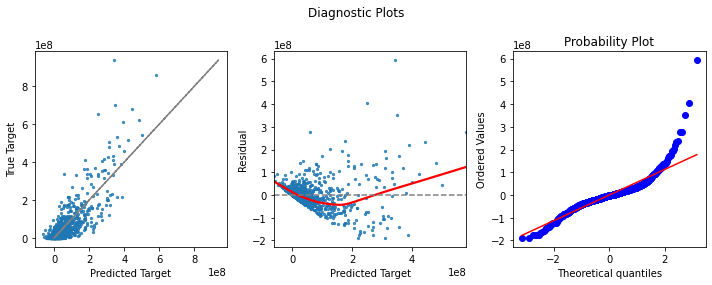

In [83]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

*This is roughly what we want to see.* In general:

1. Left Plot: The points should be close to the gray line.
2. Middle Plot: The points should look random, and the red line should be straight, left to right
3. Right Plot: The points should be close to the red line.

Statsmodels has [plenty](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html) more diagnostic plots for those who are interested.

## Seaborn for Exploring Distributions
Your **R<sup>2</sup>** should be 0.6767, not bad.  That means we believe we can explain about 67.67% of the variance in price with this model.  

One thing we will be discussing next week is Linear Regression assumptions and one being: normal distribution of the predictor variable.  Perhaps you noticed from our pairplot above that our 'gross_usa' variable is skewed.  Transform the y variable and rerun your OLS model.  Are there any other variables we should transform, why? 

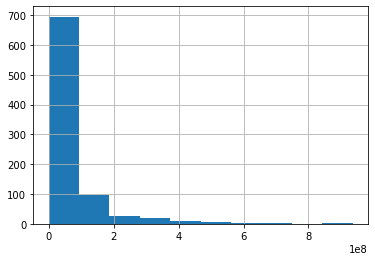

In [84]:
movies_df_drop['gross usa'].hist();

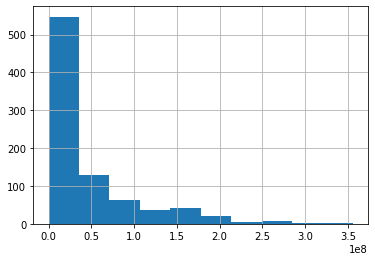

In [85]:
movies_df_drop['budget'].hist();

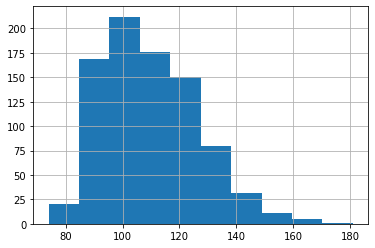

In [86]:
movies_df_drop['runtime (min)'].hist();

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


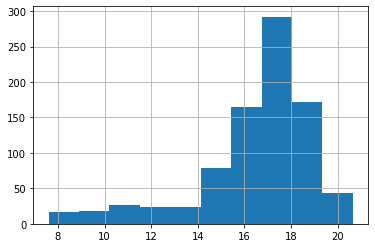

In [87]:
# take log of gross usa and graph
movies_df_drop['LOG_gross usa']=np.log(movies_df_drop['gross usa'])
# looks better
movies_df_drop['LOG_gross usa'].hist();

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


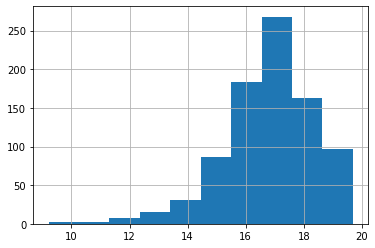

In [88]:
# take log of gross usa and graph
movies_df_drop['LOG_budget']=np.log(movies_df_drop['budget'])
# looks better
movies_df_drop['LOG_budget'].hist();

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


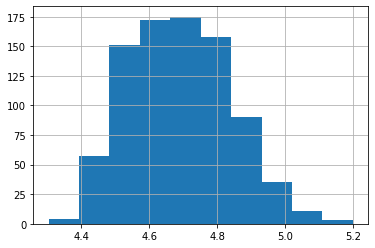

In [89]:
# take log of gross usa and graph
movies_df_drop['LOG_runtime (min)']=np.log(movies_df_drop['runtime (min)'])
# looks better
movies_df_drop['LOG_runtime (min)'].hist();

In [90]:
X, y = df_lan_model, movies_df_drop['LOG_gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5830


In [91]:
X, y = movies_df_drop[['LOG_budget', 'LOG_runtime (min)']], movies_df_drop['LOG_gross usa']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.4967


# Cross Validataion Train / Validation / Test

In [92]:
y=movies_df_drop['gross usa']
X, y = df_lan_model, y

In [93]:
X, X_test, y, y_test = train_test_split(X, y,test_size=.2,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=.20,random_state=42)

In [94]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
lr = model.fit(X_train,y_train)

r_squared_train = lr.score(X_train, y_train)
r_squared_val = lr.score(X_val, y_val)
r_squared_test = lr.score(X_test, y_test)

print(r_squared_train)
print(r_squared_val)
print(r_squared_test)

0.6392545948276357
0.6121851174041694
0.595782483683816


How would you describe the generalization error between the train and validation data sets?

No overfitting (r^2 decrease <.005)

In [95]:
# Let's first test Linear Regression vs Polynomial Features
lr = LinearRegression()

poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lr_poly = LinearRegression()

In [96]:
lr.fit(X_train, y_train)
print(f'Linear Regression val R-squared: {lr.score(X_val, y_val):.3f}')

lr_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R-squared: {lr_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R-squared: 0.612
Degree 2 polynomial regression val R-squared: 0.083


The 2 degree polynomial regression does not perform as good as the linear regression.

Perform 5-fold cross validation on the data. Before doing so, leave 20% of the data as test. Use 42 for your random state value.


In [97]:
y=movies_df_drop['gross usa']
X, y = df_lan_model, y
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X, y = np.array(X), np.array(y) # --> Necessary for next block of code
lr = LinearRegression()

In [98]:
# Here we'll validate our Linear model vs. the Ridge model
kf = KFold(n_splits=5, shuffle=True, random_state = 61)
cv_lr_r2s, cv_lr_reg_r2s = [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #Linear Regression
    lr = LinearRegression()
    #lr_reg = Ridge(alpha=1)

    lr.fit(X_train, y_train)
    cv_lr_r2s.append(lr.score(X_val, y_val))
    
print('Simple regression scores: ', cv_lr_r2s)

print(f'Simple mean cv R-squared: {np.mean(cv_lr_r2s):.3f} +- {np.std(cv_lr_r2s):.3f}')

Simple regression scores:  [0.10523303920783045, 0.36066991364567047, -0.08319010876555688, 0.4923435952212213, 0.5627403932369304]
Simple mean cv R-squared: 0.288 +- 0.242


Fit the final model on the training data then score it on the test data set. Report the `train_r2` and `test_r2`.

In [99]:
X, y = df_lan_model, y
lm = LinearRegression()
lm.fit(X_train, y_train)
train_score = lm.score(X_train, y_train)
test_score = lm.score(X_test, y_test)
print('Train Score: ', lm.score(X_train, y_train))
print('Test Score: ', lm.score(X_test, y_test))
list(zip(X.columns, lr.coef_))

Train Score:  0.6457172225666903
Test Score:  0.623365154554862


[('budget', 1.2349954242478764),
 ('runtime (min)', 591457.0432406653),
 ('G', -2373109.4565319605),
 ('Not Rated', -4064237.9492527945),
 ('PG', 19006269.03967246),
 ('PG-13', 11397095.541525088),
 ('R', 2143452.6591161815),
 ('TV-MA', -9326225.098513654),
 ('Unrated', -16783244.736148704),
 ('Action', -10040378.97442726),
 ('Adventure', -19014251.700725384),
 ('Animation', 17492854.120449536),
 ('Biography', -8596197.478714742),
 ('Comedy', 2701950.4647199064),
 ('Crime', 6821845.254805401),
 ('Drama', -7838829.184373049),
 ('Family', 13160015.03479974),
 ('Fantasy', -26654008.21960274),
 ('History', -8044696.021113135),
 ('Horror', 16470317.972201044),
 ('Music', 15805164.64376316),
 ('Musical', 26691148.37113284),
 ('Mystery', 2534733.668074444),
 ('Romance', -2238800.7509081513),
 ('Sci-Fi', 19052784.419041783),
 ('Sport', -19950175.515154973),
 ('Thriller', -11124185.692122709),
 ('War', 7262309.6647267025),
 ('Western', -5138836.65893729),
 ('Andrew Erwin', 14692471.667230334),


Is the final model overfit?
Slightly overfit 
Not overfit

How would you describe the generalization error between the train and test data sets?
* A. Very overfit (r^2 decrease of .05 or greater)
*B. Slightly overfit (r^2 decrease of .01-.05)
*C. Minimal overfitting (r^2 decrease of .005-.01)
*D. No overfitting (r^2 decrease <.005) 

# Regularization

We have a baseline model, let's fit a ridge regression on the same data. Report the validation r^2. Make sure to standardize your variables beforehand. Set the value of alpha to 2000.


In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set

y=movies_df_drop['gross usa']
X, y = df_lan_model, y

std = StandardScaler()
std.fit(X_train)

## apply the scaler to the train set
X_tr = std.transform(X_train)
## Apply the scaler to the test set
X_te = std.transform(X_test)

from sklearn.linear_model import Ridge

lr_model_ridge = Ridge(alpha = 2000)
lr_model_ridge.fit(X_tr, y_train)
ridge_test_r2 = lr_model_ridge.score(X_te, y_test)
ridge_test_r2

0.3814241055893245

In [101]:
print(lr_model_ridge.score(X_tr, y_train))
print(lr_model_ridge.score(X_te, y_test))
list(zip(X.columns, lr_model_ridge.coef_))

0.38034202316252175
0.3814241055893245


[('budget', 10780412.084706543),
 ('runtime (min)', 4832957.795100542),
 ('G', 1908130.6077559672),
 ('Not Rated', -1169305.0792050967),
 ('PG', 1054820.015213371),
 ('PG-13', 1848164.348739223),
 ('R', -2331131.418098206),
 ('TV-MA', -664117.81535388),
 ('Unrated', -697158.5470059315),
 ('Action', 2816191.5599193294),
 ('Adventure', 4826094.634195091),
 ('Animation', 2382356.790802037),
 ('Biography', -1305501.8625454577),
 ('Comedy', 43149.41567749779),
 ('Crime', -1061669.007894868),
 ('Drama', -3940825.5850247624),
 ('Family', 1747727.5728381097),
 ('Fantasy', 1237168.0623707236),
 ('History', -948101.8497623375),
 ('Horror', -862405.6182468939),
 ('Music', 389624.44195031084),
 ('Musical', 1538952.93952671),
 ('Mystery', -772122.8281505468),
 ('Romance', -1535137.7765315627),
 ('Sci-Fi', 4698432.106487452),
 ('Sport', -1110111.2179371451),
 ('Thriller', -1686808.1387766208),
 ('War', -312819.0059558307),
 ('Western', -308298.81235368236),
 ('Andrew Erwin', 55571.21001843966),
 ('C

Now we need to find the optimal penalty term through cross validation. Search 200 possible values between 10^-2 and and 10^2. 

Points to consider: Do the coefficients make sense? Is performance on par with the original regression?

In [102]:
alphas = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_tr, y_train)
ridge_model.score(X_tr, y_train)
r_squared_test = ridge_model.score(X_te, y_test)
list(zip(X_train, lr_model_ridge.coef_))
alpha = ridge_model.alpha_


In [103]:
list(zip(X.columns, lr_model_ridge.coef_))


[('budget', 10780412.084706543),
 ('runtime (min)', 4832957.795100542),
 ('G', 1908130.6077559672),
 ('Not Rated', -1169305.0792050967),
 ('PG', 1054820.015213371),
 ('PG-13', 1848164.348739223),
 ('R', -2331131.418098206),
 ('TV-MA', -664117.81535388),
 ('Unrated', -697158.5470059315),
 ('Action', 2816191.5599193294),
 ('Adventure', 4826094.634195091),
 ('Animation', 2382356.790802037),
 ('Biography', -1305501.8625454577),
 ('Comedy', 43149.41567749779),
 ('Crime', -1061669.007894868),
 ('Drama', -3940825.5850247624),
 ('Family', 1747727.5728381097),
 ('Fantasy', 1237168.0623707236),
 ('History', -948101.8497623375),
 ('Horror', -862405.6182468939),
 ('Music', 389624.44195031084),
 ('Musical', 1538952.93952671),
 ('Mystery', -772122.8281505468),
 ('Romance', -1535137.7765315627),
 ('Sci-Fi', 4698432.106487452),
 ('Sport', -1110111.2179371451),
 ('Thriller', -1686808.1387766208),
 ('War', -312819.0059558307),
 ('Western', -308298.81235368236),
 ('Andrew Erwin', 55571.21001843966),
 ('C

In [104]:
ridge_model.score(X_tr, y_train)

0.623339312783912

In [105]:
r_squared_test

0.6188432663352127

In [106]:
alpha

100.0

Fit a LASSO regression using the target and features in the cell below. Holdout 20% of the data as a test dataset. Set the random state to 42. Standardize your features for modeling. Use a lambda value of 100000 (which is VERY strong). 


In [107]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train)
## apply the scaler to the train set
X_tr = std.transform(X_train)
## Apply the scaler to the test set
X_te = std.transform(X_test)
lasso = Lasso(alpha = 1000000)
lasso.fit(X_tr, y_train)
test_r_squared = lasso.score(X_te, y_test)
print(test_r_squared)
print(list(zip(X.columns, lasso.coef_)))
variables_dropped_count = 5

0.6553887667891605
[('budget', 64442697.655860156), ('runtime (min)', 10249810.839109289), ('G', -367177.0589598439), ('Not Rated', -893951.5002725496), ('PG', 1190923.6718093886), ('PG-13', 0.0), ('R', -1694129.0128678493), ('TV-MA', -0.0), ('Unrated', -73001.19873856714), ('Action', -5588199.952343921), ('Adventure', -4805762.080249016), ('Animation', 5555412.351856275), ('Biography', -965238.1394764851), ('Comedy', 0.0), ('Crime', -0.0), ('Drama', -3338655.434098419), ('Family', 1105568.3732738493), ('Fantasy', -9610963.143848002), ('History', -1569136.8488065877), ('Horror', 4327177.962550096), ('Music', 1477217.6873221525), ('Musical', 5794743.9999707965), ('Mystery', -0.0), ('Romance', 74811.49915349954), ('Sci-Fi', 5976221.245037322), ('Sport', -3186595.5344451056), ('Thriller', -2873797.4711621148), ('War', 0.0), ('Western', -942098.7236849816), ('Andrew Erwin', 314839.66033545503), ('Clint Eastwood', -0.0), ('Denis Villeneuve', -2030165.6859615818), ('Deon Taylor', 0.0), ('Eli

In [108]:
list(zip(X.columns, lasso.coef_))

[('budget', 64442697.655860156),
 ('runtime (min)', 10249810.839109289),
 ('G', -367177.0589598439),
 ('Not Rated', -893951.5002725496),
 ('PG', 1190923.6718093886),
 ('PG-13', 0.0),
 ('R', -1694129.0128678493),
 ('TV-MA', -0.0),
 ('Unrated', -73001.19873856714),
 ('Action', -5588199.952343921),
 ('Adventure', -4805762.080249016),
 ('Animation', 5555412.351856275),
 ('Biography', -965238.1394764851),
 ('Comedy', 0.0),
 ('Crime', -0.0),
 ('Drama', -3338655.434098419),
 ('Family', 1105568.3732738493),
 ('Fantasy', -9610963.143848002),
 ('History', -1569136.8488065877),
 ('Horror', 4327177.962550096),
 ('Music', 1477217.6873221525),
 ('Musical', 5794743.9999707965),
 ('Mystery', -0.0),
 ('Romance', 74811.49915349954),
 ('Sci-Fi', 5976221.245037322),
 ('Sport', -3186595.5344451056),
 ('Thriller', -2873797.4711621148),
 ('War', 0.0),
 ('Western', -942098.7236849816),
 ('Andrew Erwin', 314839.66033545503),
 ('Clint Eastwood', -0.0),
 ('Denis Villeneuve', -2030165.6859615818),
 ('Deon Taylor'

Make sure to:

* Standardize your features

* Use Cross validation to find the optimal lambda

What is the test r^2?

What is the value of the regularization parameter?

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_tr, y_train)
r_squared_train = lasso_model.score(X_tr, y_train)
r_squared_test = lasso_model.score(X_te, y_test)
alpha = lasso_model.alpha_

print(r_squared_train)
print(r_squared_test)
print(alpha)

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343997973624525e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343956393020032e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343916831323494e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097098357408768.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097080570102272.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097063959674880.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096743875341312.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096743086216704.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096742452708096.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096720425966080.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096712476055552.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096682250489856.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096435680402944.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096652814841344.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096329622164480.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684270849312973e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684265248572672e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684259952865741e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68418442303616e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684183147347763e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684181216815795e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684158397093965e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684156633911219e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684157759921306e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684146579333376e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68415220603287e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684147588292557e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684151210219187e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684152547354982e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68413688351872e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684145741800704e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68411158978944e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684126723032704e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68421775082729e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.683997663582029e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684100046230298e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6010849708555776e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6010781557874944e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.601071460039219e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600947948418048e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600946393390029e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009458803869696e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009364178599424e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600936897507328e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009370985727744e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600936618992256e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600930384339021e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600925349398272e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600940019817728e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009244606296064e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009135231369216e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600970172377651e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6010320148139264e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600927358095053e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.935567649728384e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.935545810074573e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9355250982027776e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\

0.6476138863712091
0.6328634236751922
22.739657523579275


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2419598691918592e+17, tolerance: 700459412634788.9
  positive)


Plot the LARS path of the lasso regression. 
The LARS path indicates the values of coefficients at a given regularization strength. The vertical lines indicate where a new variable 'enters' the model, becoming a non-zero coefficient. Variables that enter the model earliest are the most essential features. The far left of the chart indicates a penalty so high that all variables are zero, while the far right indicates a traditional regression.


Computing regularization path using the LARS ...


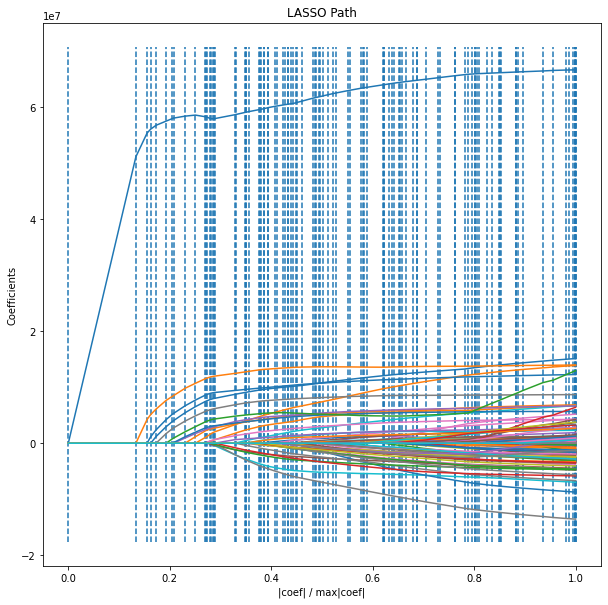

In [110]:
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt

alphas = 10**np.linspace(-2,2,200)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
#plt.legend(X_train.columns)
plt.show()

In [111]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

Fit an **Elastic Net** regression on the movies dataset using the target and features in the cell below. Holdout 20% of the data as a test dataset. Set the random state to 42. Standardize your features for modeling. Use a value alpha = 1.0 and an l1_ratio of 0.5 for the regression model.

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train.values)

## apply the scaler to the train set
X_tr = std.transform(X_train.values)

## Apply the scaler to the test set
X_te = std.transform(X_test.values)

enet = ElasticNet(alpha = 1, l1_ratio=.5)
enet.fit(X_tr, y_train)
test_r_squared = enet.score(X_te, y_test)

print(test_r_squared)
print(list(zip(X_train.columns, enet.coef_)))

enet = ElasticNet(alpha = 10000, l1_ratio=1)
enet.fit(X_tr, y_train)

#list(zip(X_train.columns, enet.coef_))

variables_dropped_count = 3

0.6222445026934444
[('budget', 30710376.36651732), ('runtime (min)', 14017343.272328863), ('G', 1404018.90532335), ('Not Rated', -2051487.6602476363), ('PG', 1060005.085218789), ('PG-13', 2757144.669351778), ('R', -2872763.114878454), ('TV-MA', -974903.9072045111), ('Unrated', -1143429.3367327845), ('Action', 882799.7606787956), ('Adventure', 4116058.9882798526), ('Animation', 4681358.472286349), ('Biography', -2571983.866456247), ('Comedy', -955795.6107141156), ('Crime', -730416.701805188), ('Drama', -6430860.967016702), ('Family', 2690396.098317388), ('Fantasy', -3809849.20431186), ('History', -2245273.3330752607), ('Horror', 990378.7330458426), ('Music', 1723678.740499489), ('Musical', 4963754.384174816), ('Mystery', -1062618.2728452957), ('Romance', -849396.1178919775), ('Sci-Fi', 7744744.875519958), ('Sport', -3382882.4543447164), ('Thriller', -3515249.625698986), ('War', -128000.45647041894), ('Western', -1490702.541532274), ('Andrew Erwin', 572300.4426123435), ('Clint Eastwood',

In [113]:
list(zip(X.columns, enet.coef_))

[('budget', 66696102.14312185),
 ('runtime (min)', 13850290.513571523),
 ('G', -2619175.498852633),
 ('Not Rated', -1544151.2327112851),
 ('PG', 2393098.1575201936),
 ('PG-13', 2862721.575981951),
 ('R', -962597.8023221911),
 ('TV-MA', -11487.117692815244),
 ('Unrated', -1303667.0911836035),
 ('Action', -6936022.209060326),
 ('Adventure', -8690988.04996263),
 ('Animation', 6668691.9929940095),
 ('Biography', -3144586.335615828),
 ('Comedy', -44282.26994910459),
 ('Crime', 898488.7648582894),
 ('Drama', -4482653.180717685),
 ('Family', 5143016.059308991),
 ('Fantasy', -13521071.103714053),
 ('History', -2437151.7301922264),
 ('Horror', 6650437.334258727),
 ('Music', 2380014.309537072),
 ('Musical', 6840326.977281034),
 ('Mystery', -941495.9961052537),
 ('Romance', 470309.6433062097),
 ('Sci-Fi', 6656917.974254045),
 ('Sport', -4756668.344560835),
 ('Thriller', -4631331.567145739),
 ('War', 983702.6771170603),
 ('Western', -2137715.7757973885),
 ('Andrew Erwin', 1126428.7176822925),
 ('C

Using cross validation, search for an optimal `l1_ratio` and `alpha` value for **Elastic Net** regression models on 5 folds of the Ames, Iowa housing dataset. Use the same *scaled* feature set ($X$) and target values ($y$) from the previous exercise (Exercise 1). Consider `ElasticNetCV`, and set the random state to 42.

* Try these `l1_ratio` values: 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, and 1
* Try 200 `alpha` values between $10^{-2}$ and $10^{2}$.


In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

alphas = 10 ** np.linspace(-2, 2, 200)

enet_model = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], 
                          alphas = alphas, 
                          cv=5,
                          random_state=42)

enet_model.fit(X_tr, y_train)

r_squared_train = enet_model.score(X_tr, y_train)
r_squared_test = enet_model.score(X_te, y_test)
alpha = enet_model.alpha_
l1_ratio = enet_model.l1_ratio_

print("r_squared_train: ", round(r_squared_train, 3))
print("r_squared_test: ", round(r_squared_test, 3))
print("alpha: ", round(alpha, 3))
print("l1_ratio: ", l1_ratio)

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554541168735488.0, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1333287635018496.0, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3028035429362944.0, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\li

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 864159282973696.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1884644560482560.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3901795030333440.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\s

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 863132477387520.0, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2039458926010368.0, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4528987167381760.0, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\li

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.727687296413508e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.102689322186358e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.47344030801482e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5698823579732416e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9137422683554778e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.276187483070866e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7104523051275494e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.174189273035643e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6167719898139354e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0859639503382272e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4820888730194726e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8911988690589914e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.076879231103181e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4431995821624704e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7846326454643136e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8762635971429274e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1367949223584013e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4007974780560666e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 796461406670080.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1423996272477952.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2455336978241792.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\s

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.348954505890222e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4780076645882234e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.598329458203362e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2232607829336205e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.58012861387999e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.92577495632624e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938561011494144.0, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1653736228290816.0, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2812868117067776.0, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\s

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.671364948382417e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8362094926173e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.986284631631813e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.123026179005001e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.324840210382656e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.508974842270271e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 711918338921472.0, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1067998201392640.0, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1564112546149888.0, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\li

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2912620529160666e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3331359803464525e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3733045548510566e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635312535181568.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 973832495253248.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1455960180860672.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\si

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3555043171515494e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4089751592167885e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4602828795660326e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 631559237654528.0, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025361164635392.0, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1617581394267904.0, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\s

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.017321442399598e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.07810013268816e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1359345325229504e+17, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693580901369344.0, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1051153628594688.0, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1555587778050816.0, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\s

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4520213550161843e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5065986911702157e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5590404630837734e+17, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489047957495552.0, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 830751361934592.0, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1366668307328000.0, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8060493615335e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.905572785199149e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.000102956446401e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.305259669254351e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3242917765704634e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.342346042627492e+17, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6876737229848858e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.69353793390699e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6935337670539827e+17, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097098357408768.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097080570102272.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097063959674880.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096793283277312.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096787903191808.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096784743707136.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096720897893888.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096726797099008.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096720213368064.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096720425966080.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096712476055552.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096682250489856.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096594815288320.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096723990808320.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096747861945856.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096657749042176.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4095745350606848.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096387087077888.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684326455542144e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684318353311846e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684310559658086e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68417679524777e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684174995821261e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684174701311437e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684152773669939e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684151523050829e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684151703031398e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684139057799219e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68415275157655e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684148552558566e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684171290885683e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684147844170906e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68411034524439e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684270228691789e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684075224467866e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684210297387955e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6011644687738624e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.601153876539341e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6011437572981504e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009808077468416e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600978569981184e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600976712386816e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.60093934283776e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009404951868416e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009377233250816e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600934054310144e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009287401716736e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600929333384883e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600997024129587e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600952764919296e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600970172377651e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

r_squared_train:  0.631
r_squared_test:  0.646
alpha:  0.168
l1_ratio:  0.1


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.503605149843533e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.503591533110106e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.503578538220506e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

**Lasso zeroed out most of the coefficients**, and **dropped the noisy collinear clone**, performing feature selection to keep the features we really wanted. 


# Lasso and Ridge and other

In [115]:
#build a hold out set to test different models
y=movies_df_drop['gross usa']
X, y = df_lan_model, y
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.2, random_state=40)

In [116]:
# Notice that we are splitting the X_train data into 5 Folds

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [117]:
#linear regression
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

[0.50738799 0.50581353 0.55346653 0.55849868 0.68290598]
Linear Reg Mean Score:  0.5616145401460739


LinearRegression()

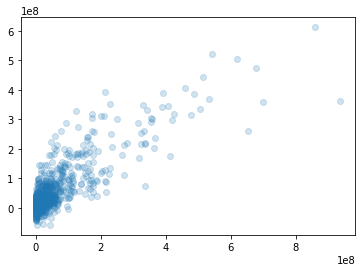

In [118]:
#evaluating Model
# Fitted vs. Actual
y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 10], [0, 10])

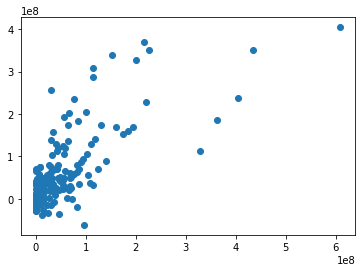

In [119]:
# Fitted vs. Actual
y_test_pred = lin_reg_est.predict(X_holdout)

plt.scatter(y_holdout, y_test_pred)
plt.plot([0, 10], [0, 10])

Text(0.5, 1.0, 'Residuals vs. Predictions')

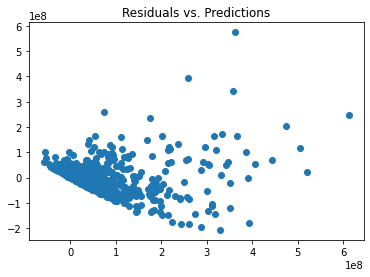

In [120]:
# Plot Residuals vs. predicted

lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Residuals vs. Predictions")

Lasso Model:


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.885822451176303e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.11933667376043e+18, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.116388437930703e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0947495914107558e+18, tolerance: 654566481346753.5
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.860318003395066e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1140084258484692e+18, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordin

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.182376365335901e+17, tolerance: 697628596233032.0
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0212757143400645e+18, tolerance: 654566481346753.5
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.971282424940236e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordina

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0094429622557696e+17, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.260931632107272e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0226732524344064e+17, tolerance: 697628596233032.0
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordin

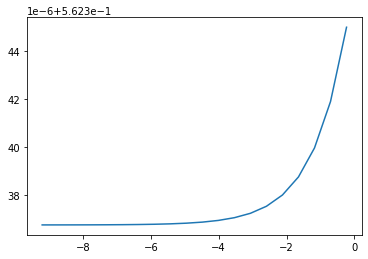

In [121]:
#Lasso
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression

from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
print("Lasso Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [122]:
grid_est.best_estimator_

Lasso(alpha=0.7943282347242815)

In [123]:
params['alpha']

array([1.00000000e-04, 1.60421716e-04, 2.57351270e-04, 4.12847324e-04,
       6.62296762e-04, 1.06246783e-03, 1.70442913e-03, 2.73427446e-03,
       4.38637001e-03, 7.03669004e-03, 1.12883789e-02, 1.81090112e-02,
       2.90507865e-02, 4.66037703e-02, 7.47625680e-02, 1.19935395e-01,
       1.92402418e-01, 3.08655261e-01, 4.95150067e-01, 7.94328235e-01])

Ridge Model:


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.79172e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.995e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.5113e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.25577e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditio

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.73171e-21): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.4326e-21): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.55693e-21): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.13827e-21): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-condit

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.04407e-19): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.64132e-19): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.61744e-19): result may not be accurate.
  overwrite_a=True).T


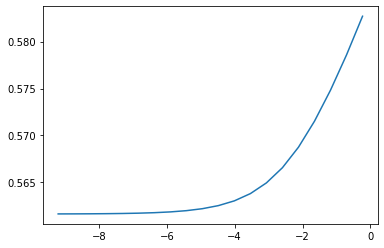

In [124]:
#ridge
print("Ridge Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Ridge(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

# Make Functions for repeatable Code 

In [125]:
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

Lasso Grid Search


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.885822451176303e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.11933667376043e+18, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.116388437930703e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0954584521256279e+18, tolerance: 654566481346753.5
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.876517551124113e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1182435482081765e+18, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordin

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.0636879308609e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0976007322491264e+18, tolerance: 697628596233032.0
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0939532729550185e+18, tolerance: 654566481346753.5
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinat

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1044701772625385e+18, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.965276653784072e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0812354877436285e+18, tolerance: 697628596233032.0
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordin

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0616187415532061e+18, tolerance: 654566481346753.5
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.947766550672744e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.98154889917374e+17, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinat

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.054759127737444e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.450428518492178e+17, tolerance: 697628596233032.0
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.326700634869905e+17, tolerance: 654566481346753.5
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinat

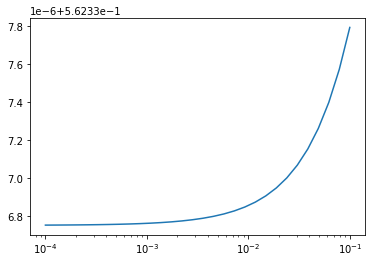

In [126]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 30))

Ridge Grid Search


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.79172e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.995e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.5113e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.25577e-23): result may not be accurate.
  overwrite_a=True).T
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditio

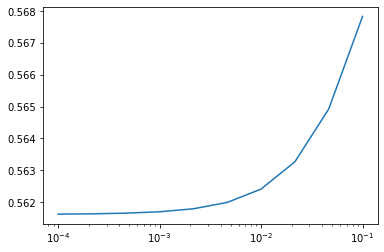

In [127]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 10))

Elastic Net Grid Search


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.907812253869906e+17, tolerance: 597403549530935.4
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1213896129167255e+18, tolerance: 722818561454554.2
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.131421411163488e+17, tolerance: 614865071040818.1
  positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordina

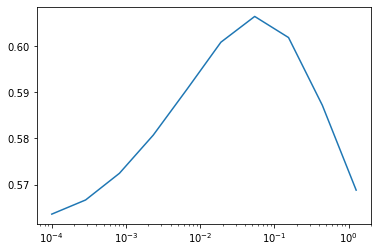

In [128]:
print("Elastic Net Grid Search")
elastic_net_grid_est = build_grid_search_est(ElasticNet(), X_train, y_train, cv=kfold,
                                             alpha=np.logspace(-4, 0.1, 10))

# Evaluating Models using Holdout Set across these four models

In [129]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = lin_reg_est.predict(X_holdout)
print("Linear Regression:", r2_score(y_holdout, y_pred))

y_pred = lasso_grid_est.predict(X_holdout)
print("Lasso Regression:", r2_score(y_holdout, y_pred))

y_pred = ridge_grid_est.predict(X_holdout)
print("Ridge Regression:", r2_score(y_holdout, y_pred))

y_pred = elastic_net_grid_est.predict(X_holdout)
print("ElasticNet Regression:", r2_score(y_holdout, y_pred))

Linear Regression: 0.4080929733581874
Lasso Regression: 0.4045896941698176
Ridge Regression: 0.4131081775179811
ElasticNet Regression: 0.39646642411853683


In [130]:
pd.DataFrame(list(zip(range(10), lasso_grid_est.best_estimator_.coef_)))

,0,1
0,0,1.351223e+00
1,1,8.431666e+05
2,2,0.000000e+00
3,3,-1.163859e+06
4,4,5.259264e+06
5,5,5.303126e+06
6,6,-1.283550e+06
7,7,1.887670e+06
8,8,-3.125270e+07
9,9,-2.183001e+07


# Other Models

In [131]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()

lm_poly = LinearRegression()
lm_poly.fit(poly.fit_transform(X_train), y_train)
y_pred = lm_poly.predict(poly.transform(X_holdout))
print("Polynomial Regression:", r2_score(y_holdout, y_pred))

Polynomial Regression: 0.22111810656560205


In [132]:
#getting fancy - we can do at least a little bit better
#(I should have cross-validated these to be rigorous)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_holdout)
print("Random Forest Regression:", r2_score(y_holdout, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_holdout)
print("Gradient Boosted Regression:", r2_score(y_holdout, y_pred))

Random Forest Regression: 0.3162735920462568
Gradient Boosted Regression: 0.5069047325566116


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


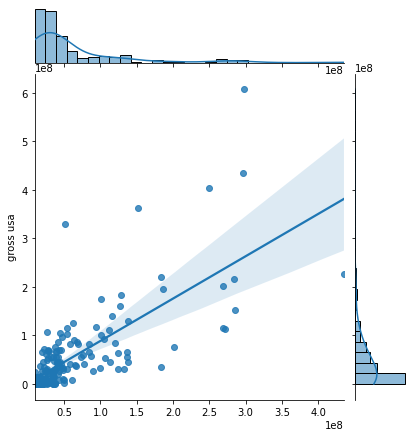

In [133]:
sns.jointplot(y_pred, y_holdout, kind='reg')

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


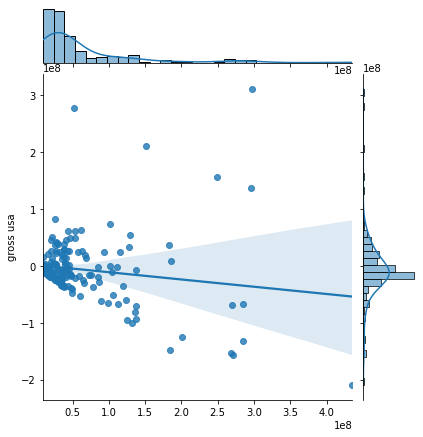

In [134]:
sns.jointplot(y_pred, y_holdout - y_pred, kind='reg')

# The Lasso has better performance than the other

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train)
## apply the scaler to the train set
X_tr = std.transform(X_train)
## Apply the scaler to the test set
X_te = std.transform(X_test)




alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_tr, y_train)
r_squared_train = lasso_model.score(X_tr, y_train)
r_squared_test = lasso_model.score(X_te, y_test)
alpha = lasso_model.alpha_

print(r_squared_train)
print(r_squared_test)
print(alpha)

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343997973624525e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343956393020032e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343916831323494e+17, tolerance: 537833545272895.94
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097136707367936.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097117267651584.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4097098357408768.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096750520375040.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096749717946624.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096746676786688.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096701212485120.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096733364870656.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096711531709440.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096869917405696.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096898555858944.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096758982519296.0, tolerance: 550924167069703.2
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684363003128934e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684353155866624e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684343791392026e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684170067971661e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684170499222912e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684169690091571e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68415220603287e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684147588292557e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684145192460774e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684133521139968e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68415886723159e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684145093029555e+16, tolerance: 606815005497184.8
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pytho

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6011644687738624e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.601153876539341e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6011437572981504e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\py

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009607064559104e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009597949325056e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009581073757696e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009370985727744e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009392360688896e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009397276002304e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600927068969549e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600948040205312e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6009408922301696e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyt

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600997024129587e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600952764919296e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.600970172377651e+16, tolerance: 649803085735593.5
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\pyth

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.503605149843533e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.503591533110106e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.503578538220506e+16, tolerance: 454407284607655.06
  tol, rng, random, positive)
c:\users\15107\appdata\local\programs\python\p

0.6476138863712091
0.6328634236751922
22.739657523579275


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2419598691918592e+17, tolerance: 700459412634788.9
  positive)


In [136]:
list(zip(X.columns, lasso.coef_))

[('budget', 64442697.655860156),
 ('runtime (min)', 10249810.839109289),
 ('G', -367177.0589598439),
 ('Not Rated', -893951.5002725496),
 ('PG', 1190923.6718093886),
 ('PG-13', 0.0),
 ('R', -1694129.0128678493),
 ('TV-MA', -0.0),
 ('Unrated', -73001.19873856714),
 ('Action', -5588199.952343921),
 ('Adventure', -4805762.080249016),
 ('Animation', 5555412.351856275),
 ('Biography', -965238.1394764851),
 ('Comedy', 0.0),
 ('Crime', -0.0),
 ('Drama', -3338655.434098419),
 ('Family', 1105568.3732738493),
 ('Fantasy', -9610963.143848002),
 ('History', -1569136.8488065877),
 ('Horror', 4327177.962550096),
 ('Music', 1477217.6873221525),
 ('Musical', 5794743.9999707965),
 ('Mystery', -0.0),
 ('Romance', 74811.49915349954),
 ('Sci-Fi', 5976221.245037322),
 ('Sport', -3186595.5344451056),
 ('Thriller', -2873797.4711621148),
 ('War', 0.0),
 ('Western', -942098.7236849816),
 ('Andrew Erwin', 314839.66033545503),
 ('Clint Eastwood', -0.0),
 ('Denis Villeneuve', -2030165.6859615818),
 ('Deon Taylor'

In [137]:
test_set_pred = lasso_model.predict(X_te)

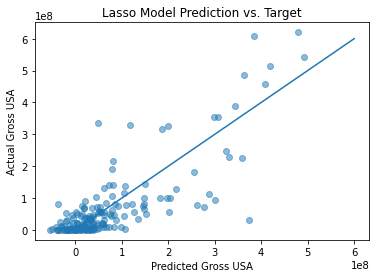

In [138]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,600000000), np.linspace(0,600000000))
plt.title('Lasso Model Prediction vs. Target')
plt.xlabel('Predicted Gross USA')
plt.ylabel('Actual Gross USA');
# The plot looks fairly decent

In [139]:
print('Lasso R-squared: {:.4f}'.format(r2_score(y_test, test_set_pred))) 
# Also, this r2 score doesn't look too bad either

Lasso R-squared: 0.6329


In [140]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

print('MAE: {:.4f}'.format(mae(y_test, test_set_pred)))
# And the MAE isn't terrible either

MAE: 47429832.5775


In [141]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

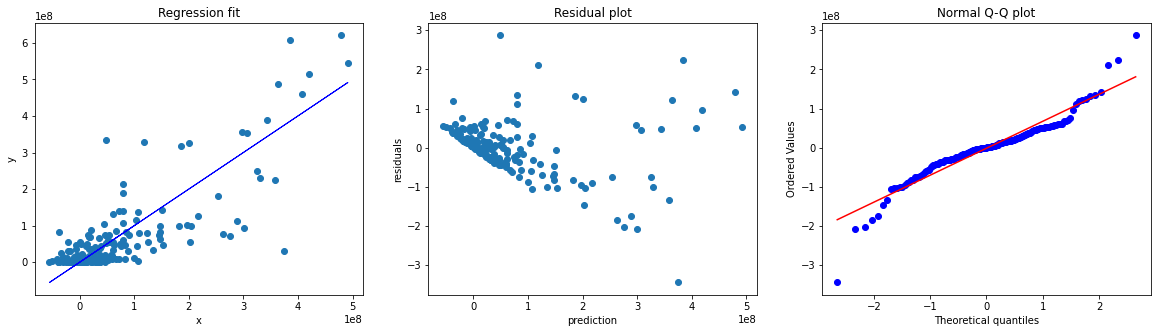

In [142]:
diagnostic_plot(test_set_pred, y_test)
# The head and tails of the Q-Q plot seem to tell a story about our data.
# Also, there seems to be an outlier than may be messing up our model, shown in the Regression fit.

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


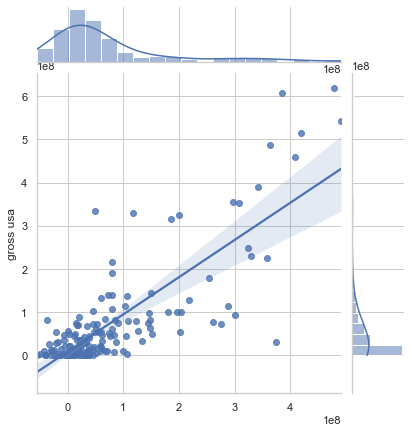

In [153]:
sns.jointplot(test_set_pred, y_test, kind='reg')

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


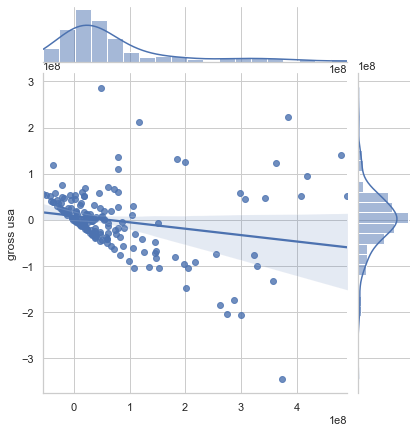

In [154]:
sns.jointplot(test_set_pred, y_test - test_set_pred, kind='reg')

# Which feature is the most important

In [143]:
coef_zip = list(zip(df_lan_model.columns.tolist(), lasso.coef_))
sorted_coef = sorted(coef_zip, key = lambda x: abs(x[1])) 
#use the absolute value of the coefficients tells which feature is most important in regards to the model

In [144]:
sorted_coef[:-100:-1]
# Select the top 30 features and their corresponding coefficients

[('budget', 64442697.655860156),
 ('Walt Disney Pictures', 13649693.04899042),
 ('Rhett Reese', 12331597.645591758),
 ('Universal Pictures', 11433968.394980786),
 ('runtime (min)', 10249810.839109289),
 ('Fantasy', -9610963.143848002),
 ('Chris McKenna', 8541362.569574269),
 ('Sci-Fi', 5976221.245037322),
 ('Musical', 5794743.9999707965),
 ('Action', -5588199.952343921),
 ('Animation', 5555412.351856275),
 ('Kevin Hart', 5456430.895569746),
 ('USA', 4859128.584634508),
 ('Adventure', -4805762.080249016),
 ('Paramount Pictures', -4728709.101947971),
 ('Horror', 4327177.962550096),
 ('Steven Spielberg', -4096772.360441114),
 ('Woody Harrelson', -3942620.345612867),
 ('New Line Cinema', 3741946.5672536055),
 ('Drama', -3338655.434098419),
 ('Perfect World Pictures', -3288395.227579667),
 ('Sport', -3186595.5344451056),
 ('Warner Bros.', -2976906.3489758475),
 ('Thriller', -2873797.4711621148),
 ('Portuguese', -2379913.2784725805),
 ('Blumhouse Productions', 2194605.8716780622),
 ('Tom Han

In [145]:
plot_name = [name[0].title() for name in sorted_coef[:-15:-1]]
plot_coef = [coef[1] for coef in sorted_coef[:-15:-1]]
colors = [0 if c>=0 else 1 for c in plot_coef]
# Setting up the parameters to plot the most important features

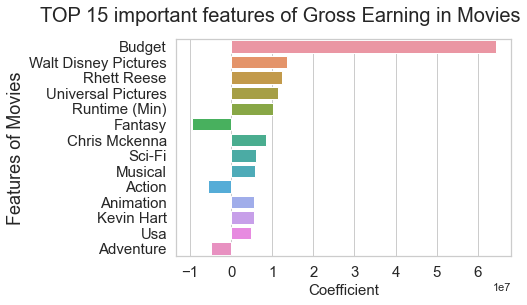

In [158]:
sns.set_theme(style="whitegrid")
movie_coef = sns.barplot(
    y=plot_name,
    x=plot_coef,
    #hue=colors,
    #palette=cmap,
    orient='h',
    )
movie_coef.set_title('TOP 15 important features of Gross Earning in Movies',fontsize=20,y=1.05, x=0.31)
#movie_coef.get_legend().set_visible(False)
movie_coef.set_xlabel('Coefficient',fontsize=15)
movie_coef.set_ylabel('Features of Movies',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
fig = movie_coef.get_figure()
# fig.savefig('top_features.png', bbox_inches='tight');